In [ ]:
# Mount Google Drive if you're using files from there
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pandas

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install matplotlib statsmodels arch pymc ruptures

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import pymc as pm
import ruptures as rpt

In [ ]:
def load_and_inspect_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)
    print("Data Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nData Sample:")
    print(df.head())
    return df

df = load_and_inspect_data('/content/drive/My Drive/Kifiya/week 10/BrentOilPrices.csv')

<ipython-input-40-856f7d967343>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9011 non-null   datetime64[ns]
 1   Price   9011 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 140.9 KB
None

Missing Values:
Date     0
Price    0
dtype: int64

Data Sample:
        Date  Price
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63


In [ ]:
def preprocess_data(df):
    df.dropna(inplace=True)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    return df

df = preprocess_data(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9011 entries, 1987-05-20 to 2022-11-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   9011 non-null   float64
dtypes: float64(1)
memory usage: 140.8 KB
None
            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63


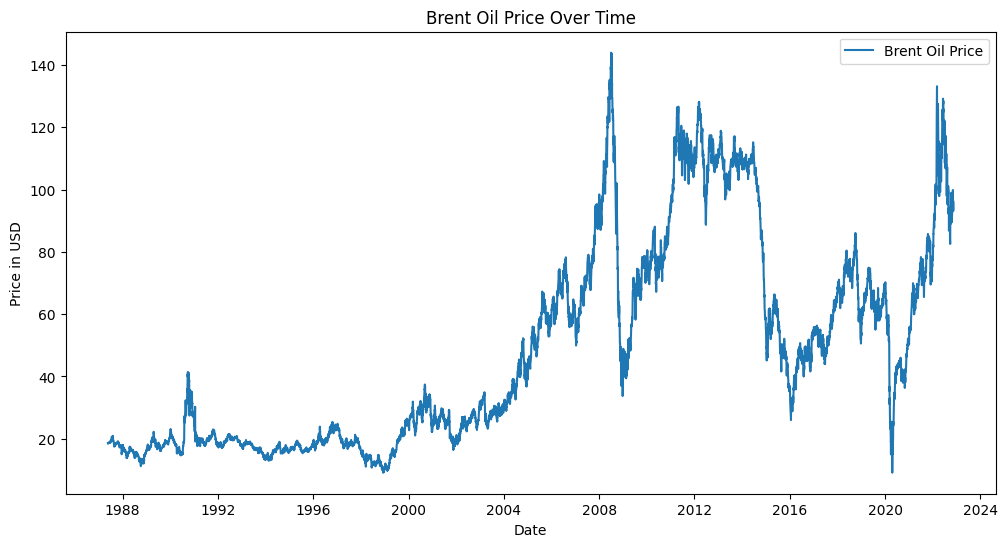

In [ ]:
import matplotlib.pyplot as plt


# df.set_index('Date', inplace=True)

# Initial Exploration
print(df.info())
print(df.head())

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], label='Brent Oil Price')
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9011 entries, 1987-05-20 to 2022-11-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   9011 non-null   float64
dtypes: float64(1)
memory usage: 140.8 KB
None
            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63


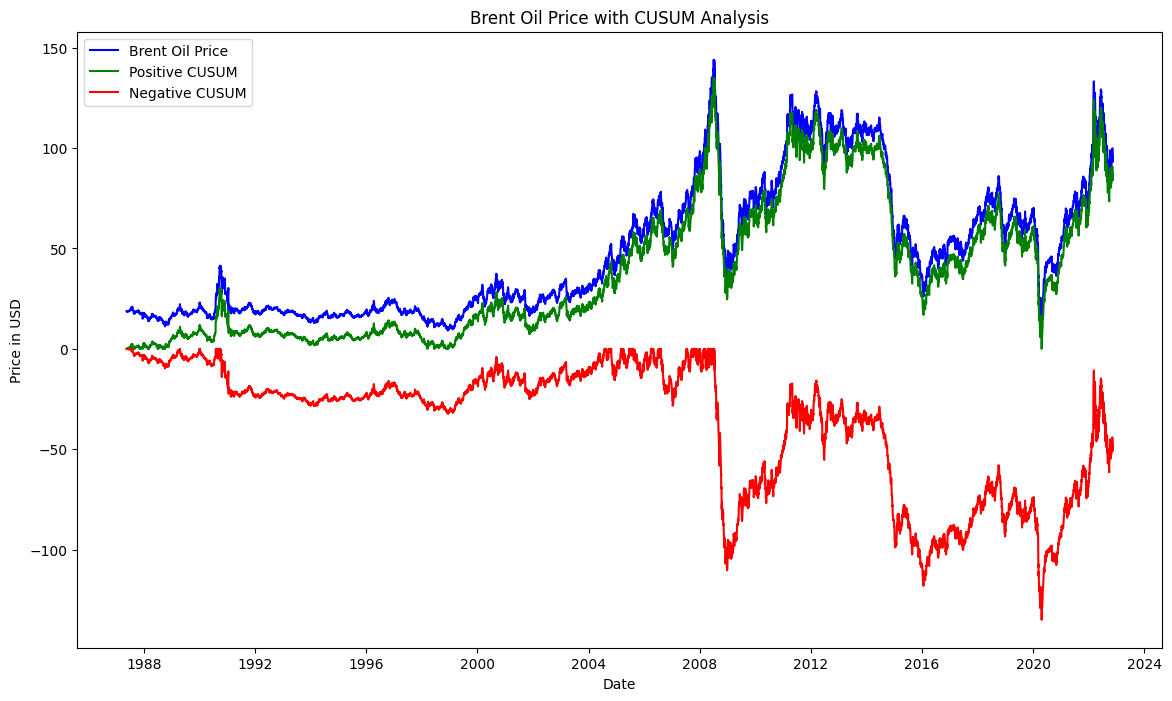

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


print(df.info())
print(df.head())

# Calculate the CUSUM for positive and negative changes
def cusum(data, threshold=0):
    pos_cusum = [0]  # Initialize CUSUM lists with 0
    neg_cusum = [0]

    for i in range(1, len(data)):
        # Positive CUSUM
        pos_cusum_val = max(0, pos_cusum[i - 1] + data[i] - data[i - 1] - threshold)
        pos_cusum.append(pos_cusum_val)

        # Negative CUSUM
        neg_cusum_val = min(0, neg_cusum[i - 1] + data[i] - data[i - 1] + threshold)
        neg_cusum.append(neg_cusum_val)

    return np.array(pos_cusum), np.array(neg_cusum)

# Applying CUSUM function
threshold = 0  # Set threshold based on sensitivity needed
df['Positive CUSUM'], df['Negative CUSUM'] = cusum(df['Price'].values, threshold)

# Plotting the original series and CUSUM analysis
plt.figure(figsize=(14, 8))

# Original time series
plt.plot(df['Price'], label='Brent Oil Price', color='blue')
plt.title('Brent Oil Price with CUSUM Analysis')
plt.xlabel('Date')
plt.ylabel('Price in USD')

# Plot positive CUSUM
plt.plot(df.index, df['Positive CUSUM'], label='Positive CUSUM', color='green')

# Plot negative CUSUM
plt.plot(df.index, df['Negative CUSUM'], label='Negative CUSUM', color='red')

# Customize the plot
plt.legend()
plt.show()


Summary Statistics:
 count    9011.000000
mean       48.420782
std        32.860110
min         9.100000
25%        19.050000
50%        38.570000
75%        70.090000
max       143.950000
Name: Price, dtype: float64


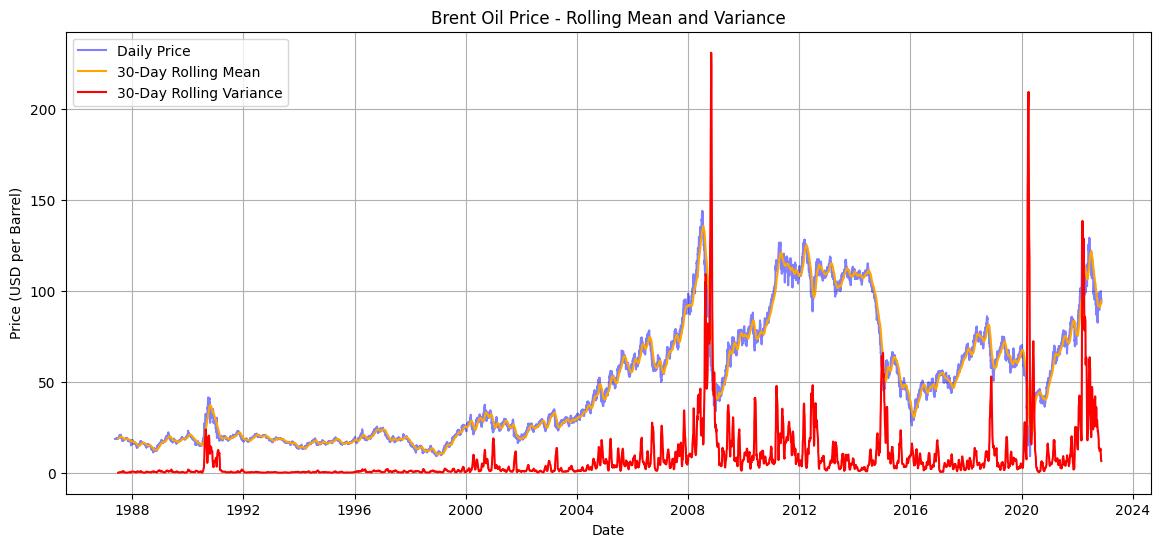

In [ ]:
# Summary statistics
print("Summary Statistics:\n", df['Price'].describe())

# Rolling mean and variance to visualize trends and volatility over time
df['Rolling_Mean'] = df['Price'].rolling(window=30).mean()  # 30-day rolling mean
df['Rolling_Variance'] = df['Price'].rolling(window=30).var()  # 30-day rolling variance

# Plot rolling mean and variance
plt.figure(figsize=(14, 6))
plt.plot(df['Price'], color='blue', alpha=0.5, label='Daily Price')
plt.plot(df['Rolling_Mean'], color='orange', label='30-Day Rolling Mean')
plt.plot(df['Rolling_Variance'], color='red', label='30-Day Rolling Variance')
plt.title('Brent Oil Price - Rolling Mean and Variance')
plt.xlabel('Date')
plt.ylabel('Price (USD per Barrel)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def feature_engineering(df):
    df['Price_Diff'] = df['Price'].diff()
    df['Log_Return'] = np.log(df['Price'] / df['Price'].shift(1))
    df['MA_7'] = df['Price'].rolling(window=7).mean()
    df['MA_30'] = df['Price'].rolling(window=30).mean()
    return df


df = feature_engineering(df)

def resample_data(df, freq='ME'):
    resampled_df = df['Price'].resample(freq).mean()
    return resampled_df

monthly_df = resample_data(df, freq='ME')

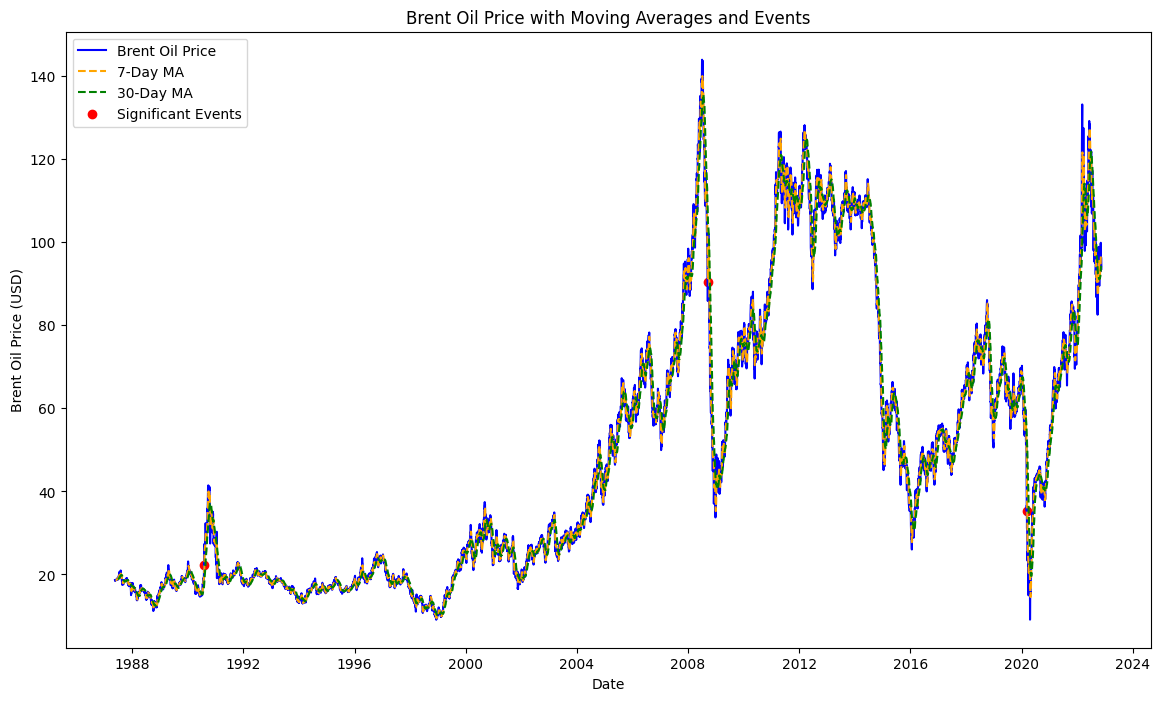

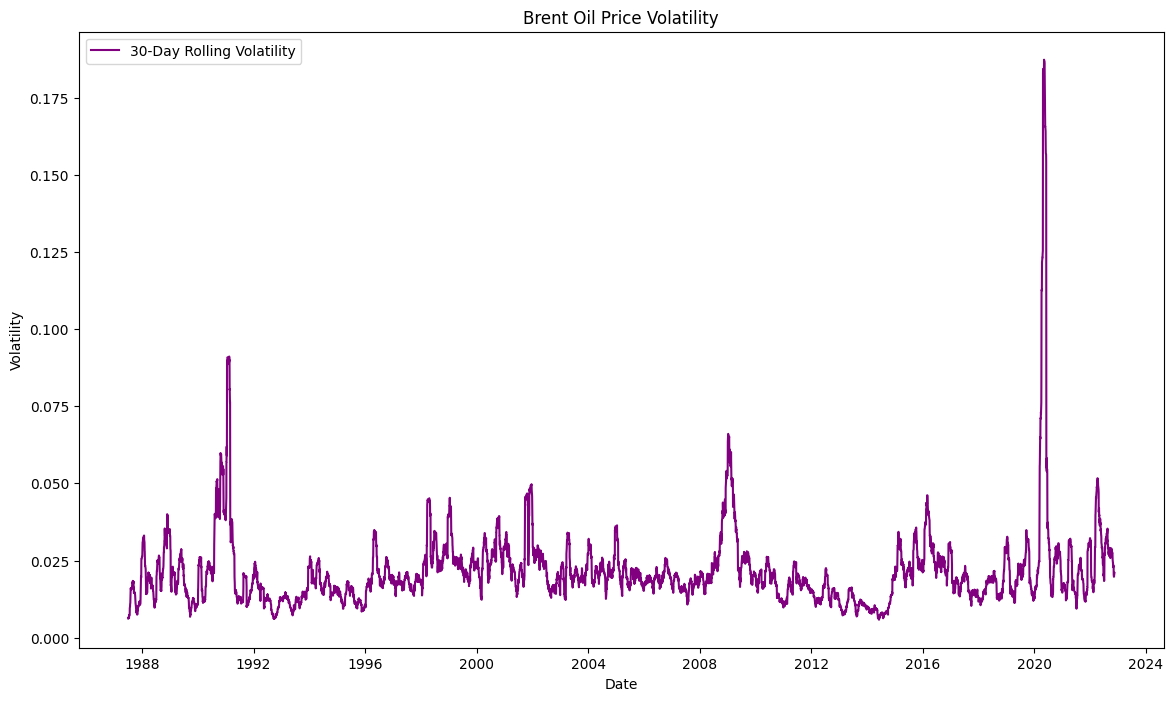

In [ ]:

def annotate_events(df, events):
    events_df = pd.DataFrame(events)
    events_df['Date'] = pd.to_datetime(events_df['Date'])
    events_df.set_index('Date', inplace=True)
    annotated_df = df.merge(events_df, how='left', left_index=True, right_index=True)
    return annotated_df

events = [
    {'Date': '1990-08-02', 'Event': 'Iraq Invades Kuwait', 'Category': 'Conflict'},
    {'Date': '2008-09-15', 'Event': 'Lehman Brothers Collapse', 'Category': 'Economic'},
    {'Date': '2020-03-09', 'Event': 'COVID-19 Oil Price Crash', 'Category': 'Pandemic'}
]

df = annotate_events(df, events)


def plot_data(df):
    plt.figure(figsize=(14, 8))
    plt.plot(df.index, df['Price'], label='Brent Oil Price', color='blue')
    plt.plot(df.index, df['MA_7'], label='7-Day MA', linestyle='--', color='orange')
    plt.plot(df.index, df['MA_30'], label='30-Day MA', linestyle='--', color='green')
    if 'Event' in df.columns:
        event_dates = df[df['Event'].notna()].index
        plt.scatter(event_dates, df.loc[event_dates, 'Price'], color='red', marker='o', label='Significant Events')
    plt.xlabel('Date')
    plt.ylabel('Brent Oil Price (USD)')
    plt.title('Brent Oil Price with Moving Averages and Events')
    plt.legend()
    plt.show()

plot_data(df)


def plot_volatility(df):
    plt.figure(figsize=(14, 8))
    plt.plot(df.index, df['Log_Return'].rolling(window=30).std(), label='30-Day Rolling Volatility', color='purple')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title('Brent Oil Price Volatility')
    plt.legend()
    plt.show()

plot_volatility(df)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
cp     4521.760  3.169  4516.000   4527.000      0.304    0.216     107.0   
mean1    21.421  0.278    20.903     22.003      0.007    0.005    1708.0   
mean2    75.614  0.283    75.067     76.161      0.006    0.004    2114.0   
sigma    18.586  0.141    18.318     18.853      0.003    0.002    1927.0   

       ess_tail  r_hat  
cp        195.0   1.02  
mean1    1339.0   1.00  
mean2    1321.0   1.00  
sigma    1460.0   1.00  


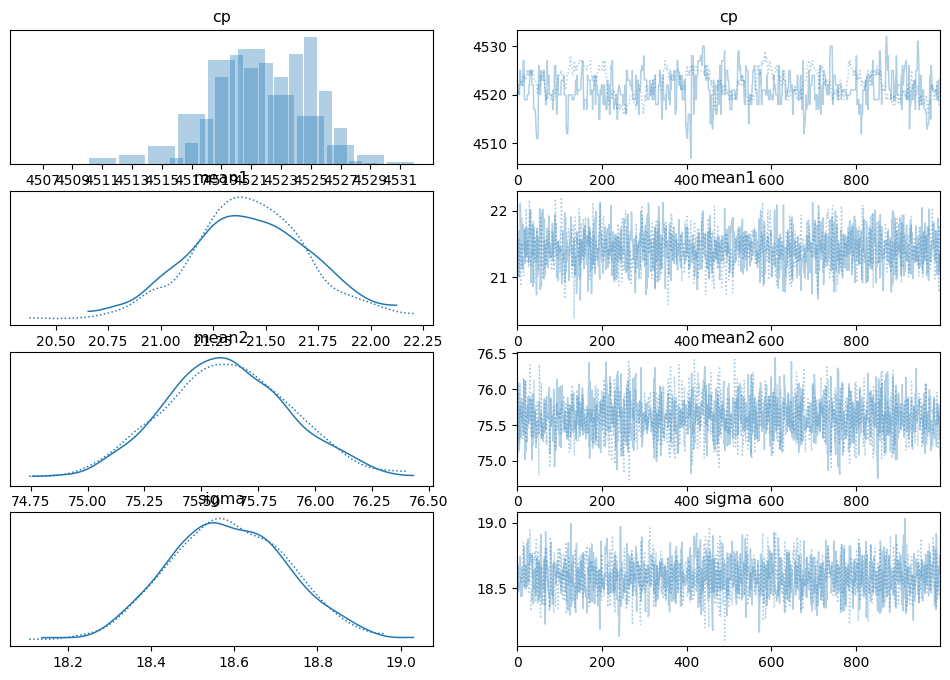

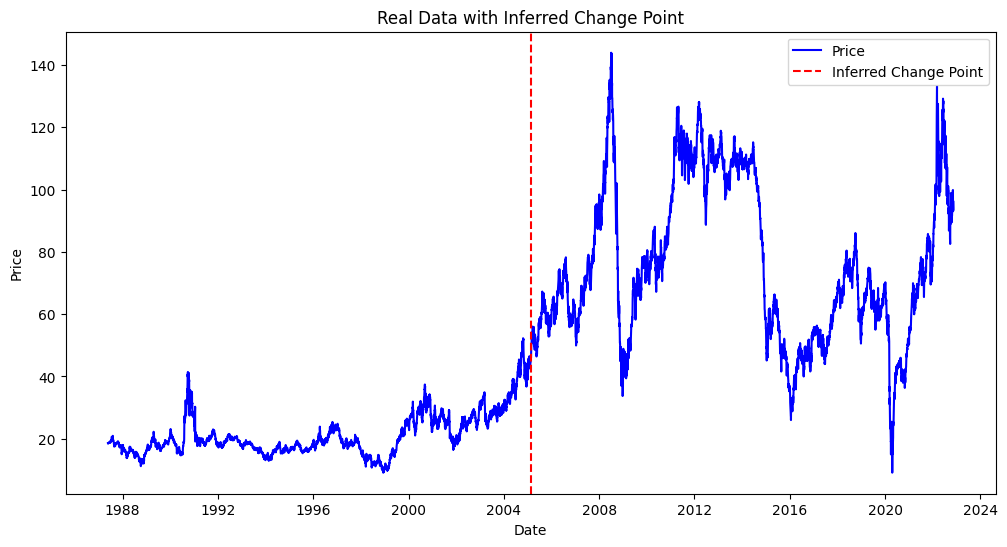

In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt


# Prepare the data
data = df['Price'].values
time = np.arange(len(data))

# Bayesian Change Point Detection Model in PyMC
with pm.Model() as model:
    # Define a prior for the change point: uniform across all time points
    cp = pm.DiscreteUniform('cp', lower=0, upper=len(data) - 1)

    # Priors for the mean before and after the change point
    mean1 = pm.Normal('mean1', mu=np.mean(data[:len(data)//2]), sigma=5)
    mean2 = pm.Normal('mean2', mu=np.mean(data[len(data)//2:]), sigma=5)

    # Prior for the standard deviation (assumed to be constant)
    sigma = pm.HalfNormal('sigma', sigma=5)

    # Likelihood: observed data with mean switching at the change point
    y = pm.Normal('y',
                  mu=pm.math.switch(cp > time, mean1, mean2),  # Change mean at the change point
                  sigma=sigma,
                  observed=data)

    # Sample from the posterior distribution
    trace = pm.sample(1000, return_inferencedata=True, tune=1000, target_accept=0.95)

# Analyze the Posterior Distribution
# Summary of the results
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

# Trace plot for visual analysis of the samples
az.plot_trace(trace)
plt.show()

# Visualize the inferred change point on the time series plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, data, label='Price', color='blue')
plt.axvline(df.index[int(np.median(trace.posterior['cp']))], color='red', linestyle='--', label='Inferred Change Point')
plt.title('Real Data with Inferred Change Point')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


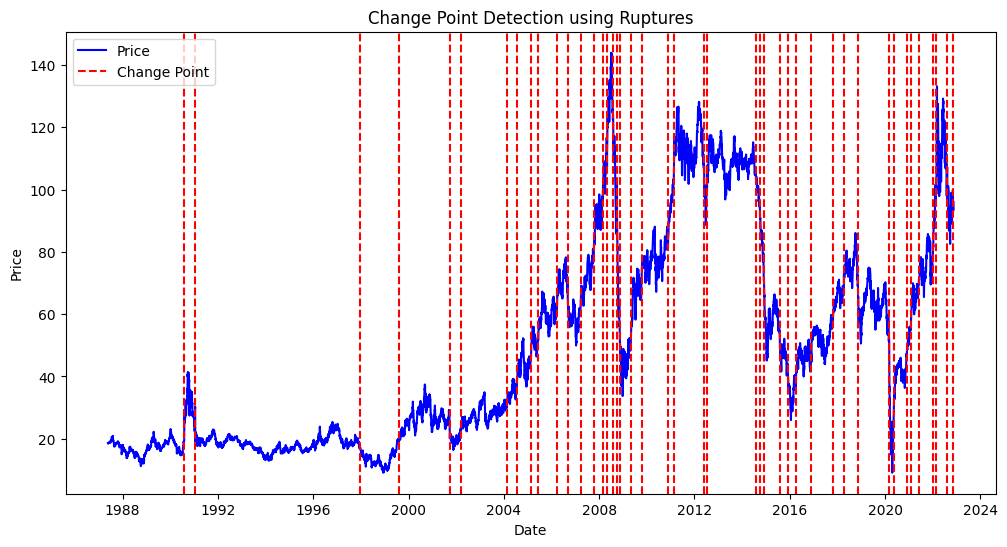

In [ ]:
import numpy as np
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt

data = df['Price'].values

model = "rbf"  # Change this to "l2" or "rbf" for different models
# Create a change point detection object
algo = rpt.Pelt(model=model).fit(data)
result = algo.predict(pen=5)  # The penalty parameter can be adjusted

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df.index, data, label='Price', color='blue')
for cp in result:
    plt.axvline(x=df.index[cp-1], color='red', linestyle='--', label='Change Point' if cp == result[0] else "")
plt.title('Change Point Detection using Ruptures')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
# Adjust the date index to a regular frequency if it's missing
df.index = pd.to_datetime(df.index).to_period('D').to_timestamp()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14543.950
Date:                Fri, 01 Nov 2024   AIC                          29093.899
Time:                        07:38:00   BIC                          29115.218
Sample:                             0   HQIC                         29101.153
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.159     -2.152      0.031      -0.655      -0.031
ma.L1          0.3712      0.157      2.358      0.018       0.063       0.680
sigma2         1.4777      0.008    184.571      0.0

Output()

Output()

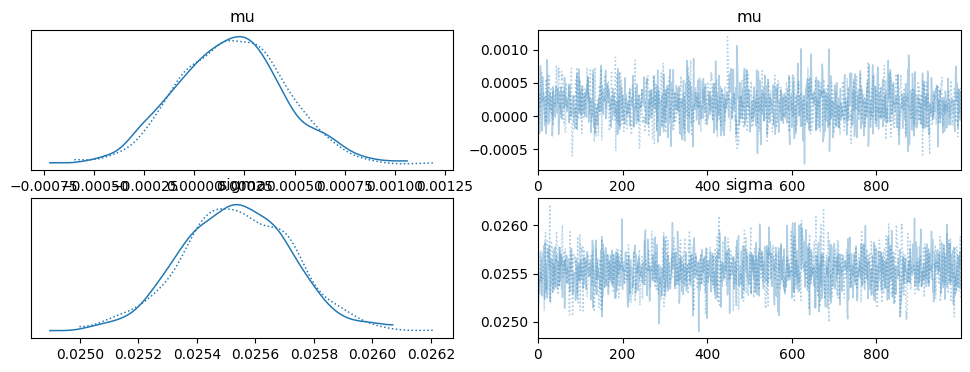

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Output()

Output()

ARIMA Model Summary:
                                SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14543.950
Date:                Fri, 01 Nov 2024   AIC                          29093.899
Time:                        07:38:58   BIC                          29115.218
Sample:                             0   HQIC                         29101.153
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.159     -2.152      0.031      -0.655      -0.031
ma.L1          0.3712      0.157      2.358      0.018       0.063       0.680
sigma2         1.4777      0.0

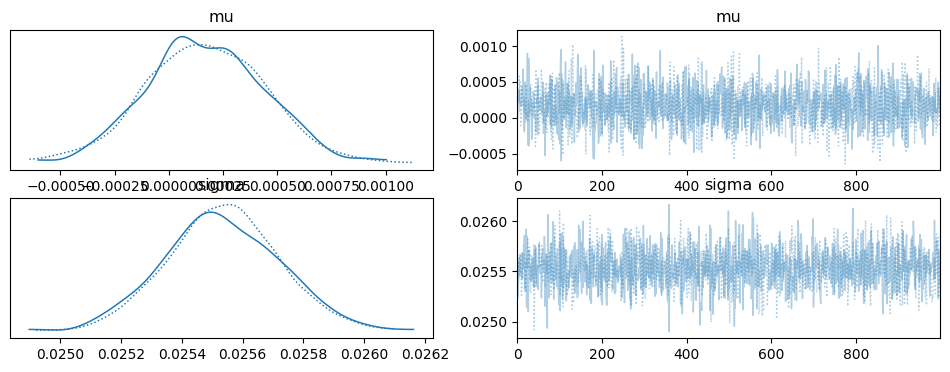

In [ ]:

import arviz as az

def arima_model(df, order=(1,1,1)):
    model = ARIMA(df['Price'].dropna(), order=order)
    arima_result = model.fit()
    return arima_result


arima_result = arima_model(df)
print(arima_result.summary())


def garch_model(df):
    model = arch_model(df['Log_Return'].dropna() * 100, vol='Garch', p=1, q=1)
    garch_result = model.fit(disp="off")
    return garch_result


garch_result = garch_model(df)
print(garch_result.summary())


def bayesian_model(df):
    with pm.Model() as model:
        mu = pm.Normal('mu', mu=0, sigma=1)
        sigma = pm.HalfNormal('sigma', sigma=1)
        obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=df['Log_Return'].dropna())
        trace = pm.sample(1000, tune=500, chains=2)
    return model, trace

# Replace pm.traceplot with az.plot_trace
bayesian_result, bayesian_trace = bayesian_model(df)
az.plot_trace(bayesian_trace)
plt.show()

def fit_and_evaluate_models(df):
    arima_result = arima_model(df)
    garch_result = garch_model(df)
    bayesian_result, bayesian_trace = bayesian_model(df)

    print("ARIMA Model Summary:\n", arima_result.summary())
    print("GARCH Model Summary:\n", garch_result.summary())

    az.plot_trace(bayesian_trace)
    plt.show()

fit_and_evaluate_models(df)


In [ ]:

def report_insights(df):
    print("Significant Events and Their Impact:\n", df[df['Event'].notna()][['Event', 'Price']])
    print("\nRisk and Volatility Indicators:\n")
    print("Mean Price:", df['Price'].mean())
    print("Standard Deviation of Returns:", df['Log_Return'].std())
    print("Volatility (30-day Rolling):\n", df['Log_Return'].rolling(30).std().mean())

report_insights(df)

Significant Events and Their Impact:
                                Event  Price
Date                                       
1990-08-02       Iraq Invades Kuwait  22.25
2008-09-15  Lehman Brothers Collapse  90.45
2020-03-09  COVID-19 Oil Price Crash  35.33

Risk and Volatility Indicators:

Mean Price: 48.42078237709467
Standard Deviation of Returns: 0.02553219808262979
Volatility (30-day Rolling):
 0.02156430721467162


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.8 MB/s eta 0:00:00
